# COVID-19 Экспоненциальный рост
КБ-211 Коренев Денис

**Задание:** Возьмите открытые данные о росте числа зараженных COVID-19 в мире или стране за три месяца. Первый месяц из трех определяется сдвигом на номер по списку с февраля 2020 года. Проверьте гипотезу о том, что этот рост описывается экспоненциальной функцией. Полученное р-значение сравните с уровнем значимости 0,05.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

### Загрузка данных

In [ ]:
# Входные данные
student_number = 11  # номер по списку
alpha = 0.05  # уровень значимости

# Определяем период анализа
# Сдвиг на 11 месяцев от февраля 2020 = январь 2021
start_month = "2021-01"  # январь 2021
end_month = "2021-03"    # март 2021

print(f"Номер по списку: {student_number}")
print(f"Сдвиг от февраля 2020: {student_number} месяцев")
print(f"Период анализа: {start_month} - {end_month}")
print(f"Уровень значимости: {alpha}")

# Загружаем данные COVID-19
data = pd.read_csv('data/_Все_случаи_по_стране_за_день_в_динамике_2022_02_15_13_57.csv')

Номер по списку: 11
Сдвиг от февраля 2020: 11 месяцев
Период анализа: 2021-01 - 2021-03
Уровень значимости: 0.05


### Подготовка данных

In [8]:
# Преобразуем дату
data['DateTime'] = pd.to_datetime(data['DateTime'])
data = data.sort_values('DateTime')

# Фильтруем данные за нужный период (январь-март 2021)
mask = (data['DateTime'] >= '2021-01-01') & (data['DateTime'] <= '2021-03-31')
covid_data = data[mask].copy()

# Вычисляем накопленное количество случаев
covid_data['Накопленные_случаи'] = covid_data['Заражений за день'].cumsum()

# Создаем переменную времени (дни от начала периода)
covid_data['День'] = (covid_data['DateTime'] - covid_data['DateTime'].min()).dt.days

print(f"\nДанные за период {start_month} - {end_month}:")
print(f"Количество дней: {len(covid_data)}")
print(f"Диапазон дат: {covid_data['DateTime'].min().date()} - {covid_data['DateTime'].max().date()}")
print(f"Общее количество случаев за период: {covid_data['Заражений за день'].sum()}")

# Показываем первые и последние записи
print("\nПервые 5 записей:")
print(covid_data[['DateTime', 'Заражений за день', 'Накопленные_случаи', 'День']].head())
print("\nПоследние 5 записей:")
print(covid_data[['DateTime', 'Заражений за день', 'Накопленные_случаи', 'День']].tail())


Данные за период 2021-01 - 2021-03:
Количество дней: 90
Диапазон дат: 2021-01-01 - 2021-03-31
Общее количество случаев за период: 1385798

Первые 5 записей:
      DateTime  Заражений за день  Накопленные_случаи  День
295 2021-01-01              27039               27039     0
296 2021-01-02              26301               53340     1
297 2021-01-03              24150               77490     2
298 2021-01-04              23351              100841     3
299 2021-01-05              24246              125087     4

Последние 5 записей:
      DateTime  Заражений за день  Накопленные_случаи  День
380 2021-03-27               8885             1351447    85
381 2021-03-28               9088             1360535    86
382 2021-03-29               8711             1369246    87
383 2021-03-30               8277             1377523    88
384 2021-03-31               8275             1385798    89


### Визуализация данных

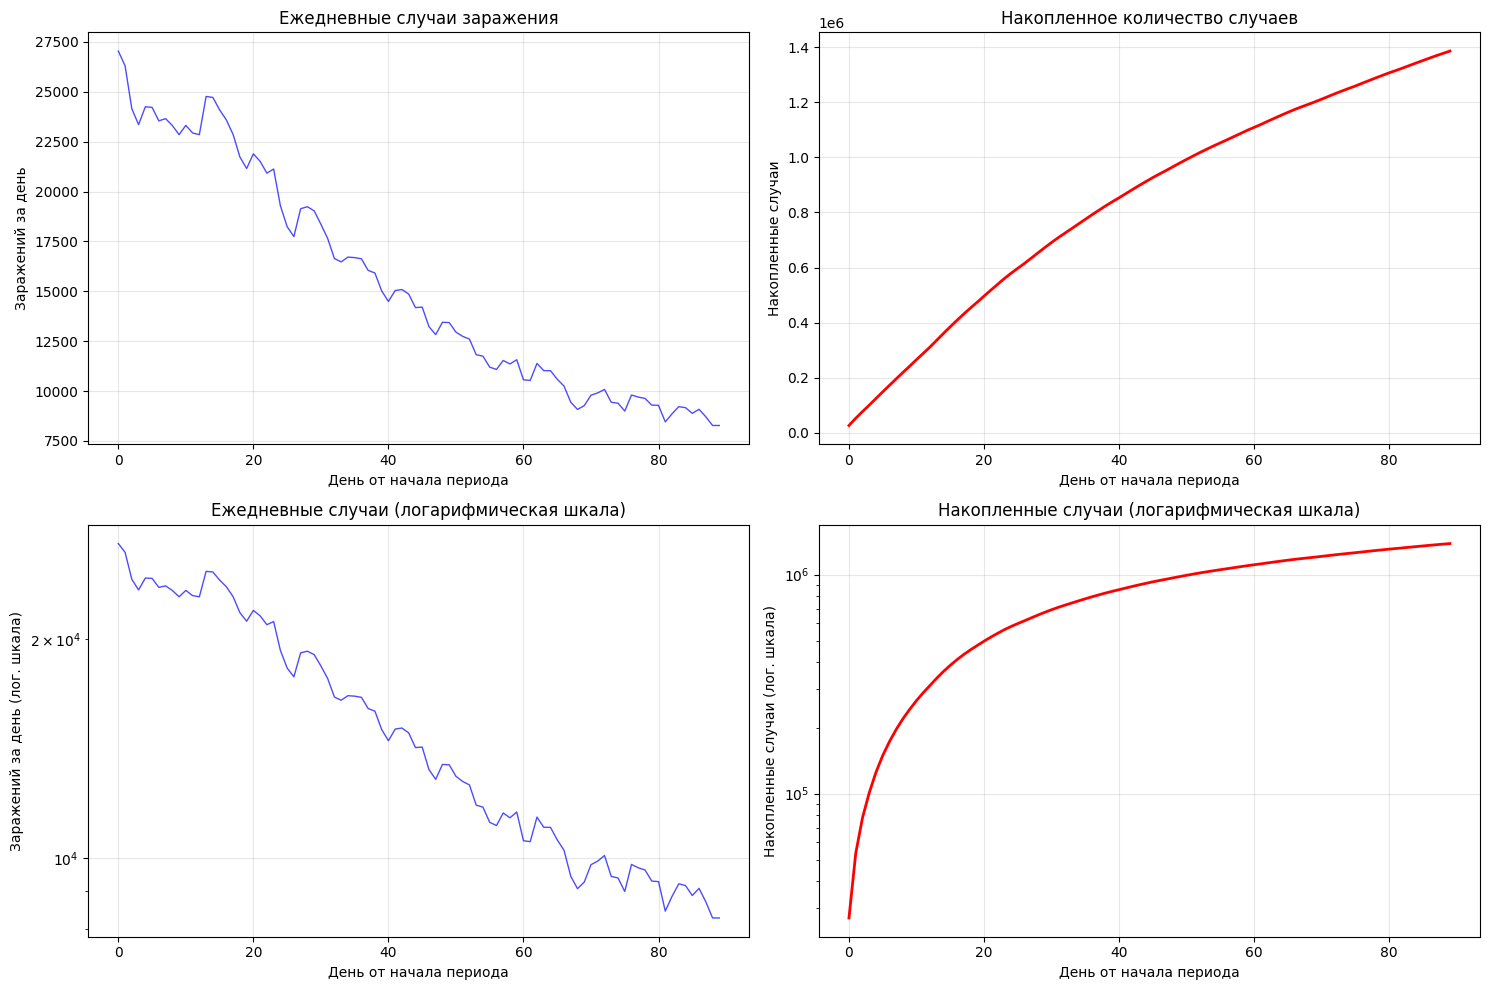

In [9]:
plt.figure(figsize=(15, 10))

# График ежедневных случаев
plt.subplot(2, 2, 1)
plt.plot(covid_data['День'], covid_data['Заражений за день'], 'b-', linewidth=1, alpha=0.7)
plt.xlabel('День от начала периода')
plt.ylabel('Заражений за день')
plt.title('Ежедневные случаи заражения')
plt.grid(True, alpha=0.3)

# График накопленных случаев
plt.subplot(2, 2, 2)
plt.plot(covid_data['День'], covid_data['Накопленные_случаи'], 'r-', linewidth=2)
plt.xlabel('День от начала периода')
plt.ylabel('Накопленные случаи')
plt.title('Накопленное количество случаев')
plt.grid(True, alpha=0.3)

# График в логарифмическом масштабе (ежедневные)
plt.subplot(2, 2, 3)
valid_daily = covid_data[covid_data['Заражений за день'] > 0]
plt.semilogy(valid_daily['День'], valid_daily['Заражений за день'], 'b-', linewidth=1, alpha=0.7)
plt.xlabel('День от начала периода')
plt.ylabel('Заражений за день (лог. шкала)')
plt.title('Ежедневные случаи (логарифмическая шкала)')
plt.grid(True, alpha=0.3)

# График в логарифмическом масштабе (накопленные)
plt.subplot(2, 2, 4)
valid_cumul = covid_data[covid_data['Накопленные_случаи'] > 0]
plt.semilogy(valid_cumul['День'], valid_cumul['Накопленные_случаи'], 'r-', linewidth=2)
plt.xlabel('День от начала периода')
plt.ylabel('Накопленные случаи (лог. шкала)')
plt.title('Накопленные случаи (логарифмическая шкала)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Проверка гипотезы об экспоненциальном росте
#### Метод 1: Анализ ежедневных случаев

In [21]:
print("="*60)
print("ПРОВЕРКА ГИПОТЕЗЫ ОБ ЭКСПОНЕНЦИАЛЬНОМ РОСТЕ")
print("="*60)

# Экспоненциальная функция: y = a * exp(b * x)
def exponential_func(x, a, b):
    return a * np.exp(b * x)

# Фильтруем положительные значения для анализа
daily_positive = covid_data[covid_data['Заражений за день'] > 0].copy()

if len(daily_positive) > 10:  # Достаточно данных для анализа
    x_data = daily_positive['День'].values
    y_data = daily_positive['Заражений за день'].values
    
    # Подгонка экспоненциальной модели
    try:
        # Начальные приближения параметров
        initial_guess = [y_data[0], 0.01]
        
        fitted_parameters, param_covariance = curve_fit(exponential_func, x_data, y_data, 
                              p0=initial_guess, maxfev=5000)
        
        a_fitted, b_fitted = fitted_parameters
        
        print(f"АНАЛИЗ ЕЖЕДНЕВНЫХ СЛУЧАЕВ:")
        print(f"Подогнанная экспоненциальная модель: y = {a_fitted:.2f} * exp({b_fitted:.6f} * x)")
        print(f"Параметр роста b = {b_fitted:.6f}")
        
        # Предсказанные значения
        y_predicted = exponential_func(x_data, a_fitted, b_fitted)
        
        # Вычисляем остатки
        residuals = y_data - y_predicted
        
        # R-квадрат
        sum_squared_residuals = np.sum(residuals ** 2)
        total_sum_squares = np.sum((y_data - np.mean(y_data)) ** 2)
        r_squared = 1 - (sum_squared_residuals / total_sum_squares)
        
        print(f"R^2 = {r_squared:.6f}")
        
    except Exception as e:
        print(f"Ошибка при подгонке экспоненциальной модели: {e}")
        fitted_parameters = None

ПРОВЕРКА ГИПОТЕЗЫ ОБ ЭКСПОНЕНЦИАЛЬНОМ РОСТЕ
АНАЛИЗ ЕЖЕДНЕВНЫХ СЛУЧАЕВ:
Подогнанная экспоненциальная модель: y = 26932.27 * exp(-0.014037 * x)
Параметр роста b = -0.014037
R^2 = 0.973176


#### Метод 2: Тест на нормальность остатков (Шапиро-Уилк)

In [26]:
if 'popt' in locals() and fitted_parameters is not None:
    print(f"\n" + "="*50)
    print("ТЕСТ ШАПИРО-УИЛКА ДЛЯ ОСТАТКОВ")
    print("="*50)
    
    # Стандартизированные остатки
    std_residuals = residuals / np.std(residuals)
    
    # Тест Шапиро-Уилка на нормальность остатков
    shapiro_stat, shapiro_p = stats.shapiro(std_residuals)
    
    print(f"Статистика Шапиро-Уилка: {shapiro_stat:.6f}")
    print(f"p-value: {shapiro_p:.6f}")
    print(f"Критическое значение alpha: {alpha}")
    
    if shapiro_p > alpha:
        shapiro_conclusion = "ПРИНИМАЕТСЯ"
        shapiro_interpretation = "Остатки распределены нормально"
    else:
        shapiro_conclusion = "ОТВЕРГАЕТСЯ"
        shapiro_interpretation = "Остатки НЕ распределены нормально"
    
    print(f"Гипотеза H0 (остатки имеют нормальное распределение): {shapiro_conclusion}")
    print(f"Интерпретация: {shapiro_interpretation}")


ТЕСТ ШАПИРО-УИЛКА ДЛЯ ОСТАТКОВ
Статистика Шапиро-Уилка: 0.975967
p-value: 0.093728
Критическое значение alpha: 0.05
Гипотеза H0 (остатки имеют нормальное распределение): ПРИНИМАЕТСЯ
Интерпретация: Остатки распределены нормально


#### Метод 3: F-тест значимости регрессии

In [28]:
if 'popt' in locals() and fitted_parameters is not None:
    print(f"\n" + "="*50)
    print("F-ТЕСТ ЗНАЧИМОСТИ РЕГРЕССИИ")
    print("="*50)
    
    n = len(x_data)  # количество наблюдений
    k = 1  # количество параметров модели (кроме константы)
    
    # Средние квадраты
    ms_regression = total_sum_squares - sum_squared_residuals  # объясненная дисперсия
    ms_residual = sum_squared_residuals / (n - k - 1)  # остаточная дисперсия
    
    # F-статистика
    f_statistic = ms_regression / ms_residual
    f_critical = stats.f.ppf(1 - alpha, k, n - k - 1)
    f_p_value = 1 - stats.f.cdf(f_statistic, k, n - k - 1)
    
    print(f"F-статистика: {f_statistic:.6f}")
    print(f"Критическое значение F({k}, {n-k-1}): {f_critical:.6f}")
    print(f"p-value: {f_p_value:.6f}")
    
    if f_statistic > f_critical:
        f_conclusion = "ОТВЕРГАЕТСЯ"
        f_interpretation = "Экспоненциальная модель статистически значима"
    else:
        f_conclusion = "ПРИНИМАЕТСЯ"
        f_interpretation = "Экспоненциальная модель НЕ значима"
    
    print(f"Гипотеза H0 (модель не значима): {f_conclusion}")
    print(f"Интерпретация: {f_interpretation}")


F-ТЕСТ ЗНАЧИМОСТИ РЕГРЕССИИ
F-статистика: 3192.590156
Критическое значение F(1, 88): 3.949321
p-value: 0.000000
Гипотеза H0 (модель не значима): ОТВЕРГАЕТСЯ
Интерпретация: Экспоненциальная модель статистически значима


#### Метод 4: Критерий хи-квадрат согласия

In [29]:
if 'popt' in locals() and fitted_parameters is not None:
    print(f"\n" + "="*50)
    print("КРИТЕРИЙ ХИ-КВАДРАТ СОГЛАСИЯ")
    print("="*50)
    
    # Разбиваем данные на интервалы для критерия хи-квадрат
    num_bins = min(8, len(y_data) // 8)  # уменьшаем количество интервалов
    
    # Создаем равномерные интервалы по диапазону наблюдаемых данных
    y_min, y_max = y_data.min(), y_data.max()
    bin_edges = np.linspace(y_min, y_max * 1.01, num_bins + 1)  # небольшое увеличение для включения максимума
    
    # Наблюдаемые частоты
    observed_freq, _ = np.histogram(y_data, bins=bin_edges)
    
    # Для теоретических частот используем ту же разбивку, но применяем к предсказанным значениям
    expected_freq, _ = np.histogram(y_predicted, bins=bin_edges)
    
    # Убеждаемся, что частоты положительные и суммы совпадают
    observed_freq = observed_freq.astype(float)
    expected_freq = expected_freq.astype(float)
    
    # Нормализуем ожидаемые частоты, чтобы их сумма равнялась сумме наблюдаемых
    if expected_freq.sum() > 0:
        expected_freq = expected_freq * (observed_freq.sum() / expected_freq.sum())
    
    # Объединяем интервалы с малыми частотами
    min_freq = 5
    while len(observed_freq) > 2 and (np.any(expected_freq < min_freq) or np.any(observed_freq < min_freq)):
        # Находим интервал с минимальной ожидаемой частотой
        min_idx = np.argmin(expected_freq)
        
        if min_idx == 0:
            # Объединяем с правым соседом
            observed_freq[1] += observed_freq[0]
            expected_freq[1] += expected_freq[0]
            observed_freq = observed_freq[1:]
            expected_freq = expected_freq[1:]
            bin_edges = bin_edges[1:]
        elif min_idx == len(expected_freq) - 1:
            # Объединяем с левым соседом
            observed_freq[-2] += observed_freq[-1]
            expected_freq[-2] += expected_freq[-1]
            observed_freq = observed_freq[:-1]
            expected_freq = expected_freq[:-1]
            bin_edges = bin_edges[:-1]
        else:
            # Объединяем с соседом, имеющим меньшую частоту
            if expected_freq[min_idx-1] <= expected_freq[min_idx+1]:
                # Объединяем с левым
                observed_freq[min_idx-1] += observed_freq[min_idx]
                expected_freq[min_idx-1] += expected_freq[min_idx]
                observed_freq = np.delete(observed_freq, min_idx)
                expected_freq = np.delete(expected_freq, min_idx)
                bin_edges = np.delete(bin_edges, min_idx)
            else:
                # Объединяем с правым
                observed_freq[min_idx+1] += observed_freq[min_idx]
                expected_freq[min_idx+1] += expected_freq[min_idx]
                observed_freq = np.delete(observed_freq, min_idx)
                expected_freq = np.delete(expected_freq, min_idx)
                bin_edges = np.delete(bin_edges, min_idx+1)
    
    # Финальная проверка и корректировка сумм
    obs_sum = observed_freq.sum()
    exp_sum = expected_freq.sum()
    
    if abs(obs_sum - exp_sum) > 1e-6:
        # Корректируем ожидаемые частоты пропорционально
        expected_freq = expected_freq * (obs_sum / exp_sum)
    
    # Убеждаемся, что все частоты положительные
    mask = (observed_freq > 0) & (expected_freq > 0)
    observed_freq = observed_freq[mask]
    expected_freq = expected_freq[mask]
    
    print(f"Количество интервалов после объединения: {len(observed_freq)}")
    print(f"Сумма наблюдаемых частот: {observed_freq.sum():.0f}")
    print(f"Сумма ожидаемых частот: {expected_freq.sum():.0f}")
    
    for i in range(len(observed_freq)):
        if i < len(bin_edges) - 1:
            interval_str = f"[{bin_edges[i]:.1f}, {bin_edges[i+1]:.1f})"
        else:
            interval_str = f"[{bin_edges[i]:.1f}, +∞)"
        
        print(f"  Интервал {i+1}: {interval_str}")
        print(f"    Наблюдаемая частота: {observed_freq[i]:.0f}")
        print(f"    Ожидаемая частота: {expected_freq[i]:.2f}")
    
    # Применяем критерий хи-квадрат только если у нас есть достаточно интервалов
    if len(observed_freq) >= 2:
        try:
            chi2_stat, chi2_p = stats.chisquare(observed_freq, expected_freq)
            
            # Степени свободы
            df = len(observed_freq) - 1 - k  # k параметров модели
            df = max(1, df)  # минимум 1 степень свободы
            
            chi2_critical = stats.chi2.ppf(1 - alpha, df)
            
            print(f"\nРезультаты критерия χ²:")
            print(f"Статистика χ²: {chi2_stat:.6f}")
            print(f"Степени свободы: {df}")
            print(f"Критическое значение χ²: {chi2_critical:.6f}")
            print(f"p-value: {chi2_p:.6f}")
            
            if chi2_stat > chi2_critical:
                chi2_conclusion = "ОТВЕРГАЕТСЯ"
                chi2_interpretation = "Данные НЕ соответствуют экспоненциальной модели"
            else:
                chi2_conclusion = "ПРИНИМАЕТСЯ"
                chi2_interpretation = "Данные соответствуют экспоненциальной модели"
            
            print(f"Гипотеза H0 (данные соответствуют экспоненциальной модели): {chi2_conclusion}")
            print(f"Интерпретация: {chi2_interpretation}")
            
        except Exception as e:
            print(f"Ошибка при применении критерия χ²: {e}")
            print("Критерий χ² не может быть применен из-за особенностей данных")
            chi2_p = None
    else:
        print("Недостаточно интервалов для применения критерия χ²")
        chi2_p = None


КРИТЕРИЙ ХИ-КВАДРАТ СОГЛАСИЯ
Количество интервалов после объединения: 7
Сумма наблюдаемых частот: 90
Сумма ожидаемых частот: 90
  Интервал 1: [8275.0, 10654.3)
    Наблюдаемая частота: 27
    Ожидаемая частота: 19.06
  Интервал 2: [10654.3, 13033.6)
    Наблюдаемая частота: 14
    Ожидаемая частота: 15.88
  Интервал 3: [13033.6, 15412.9)
    Наблюдаемая частота: 10
    Ожидаемая частота: 12.71
  Интервал 4: [15412.9, 17792.2)
    Наблюдаемая частота: 9
    Ожидаемая частота: 10.59
  Интервал 5: [17792.2, 20171.5)
    Наблюдаемая частота: 6
    Ожидаемая частота: 9.53
  Интервал 6: [20171.5, 22550.8)
    Наблюдаемая частота: 6
    Ожидаемая частота: 8.47
  Интервал 7: [22550.8, 24930.1)
    Наблюдаемая частота: 18
    Ожидаемая частота: 13.76

Результаты критерия χ²:
Статистика χ²: 7.677350
Степени свободы: 5
Критическое значение χ²: 11.070498
p-value: 0.262707
Гипотеза H0 (данные соответствуют экспоненциальной модели): ПРИНИМАЕТСЯ
Интерпретация: Данные соответствуют экспоненциальной м

### Визуализация результатов подгонки

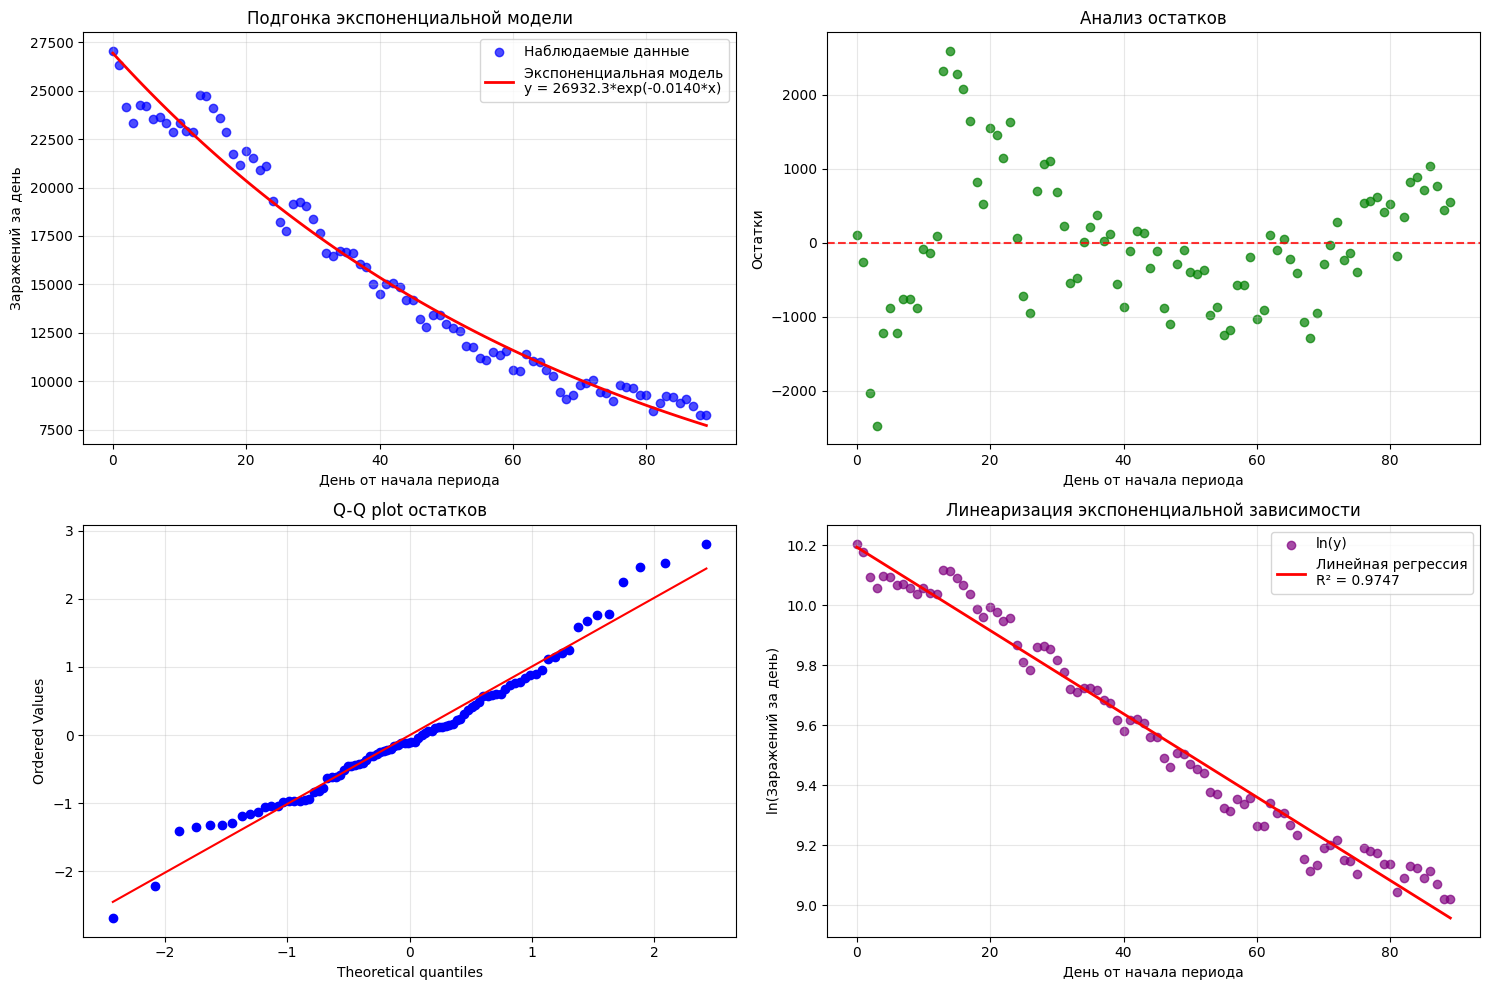


ЛИНЕЙНАЯ РЕГРЕССИЯ В ЛОГАРИФМИЧЕСКИХ КООРДИНАТАХ:
Уравнение: ln(y) = -0.013883·x + 10.193120
Коэффициент корреляции R = -0.987286
Коэффициент детерминации R^2 = 0.974733
p-value для коэффициента наклона: 0.000000


In [ ]:
if 'popt' in locals() and fitted_parameters is not None:
    plt.figure(figsize=(15, 10))
    
    # Исходные данные и подогнанная модель
    plt.subplot(2, 2, 1)
    plt.scatter(x_data, y_data, color='blue', alpha=0.7, label='Наблюдаемые данные')
    x_smooth = np.linspace(x_data.min(), x_data.max(), 100)
    y_smooth = exponential_func(x_smooth, a_fitted, b_fitted)
    plt.plot(x_smooth, y_smooth, 'r-', linewidth=2, 
             label=f'Экспоненциальная модель\ny = {a_fitted:.1f}*exp({b_fitted:.4f}*x)')
    plt.xlabel('День от начала периода')
    plt.ylabel('Заражений за день')
    plt.title('Подгонка экспоненциальной модели')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Остатки
    plt.subplot(2, 2, 2)
    plt.scatter(x_data, residuals, color='green', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.8)
    plt.xlabel('День от начала периода')
    plt.ylabel('Остатки')
    plt.title('Анализ остатков')
    plt.grid(True, alpha=0.3)
    
    # Q-Q plot для проверки нормальности остатков
    plt.subplot(2, 2, 3)
    stats.probplot(std_residuals, dist="norm", plot=plt)
    plt.title('Q-Q plot остатков')
    plt.grid(True, alpha=0.3)
    
    # Логарифмические данные для проверки линейности
    plt.subplot(2, 2, 4)
    log_y = np.log(y_data)
    plt.scatter(x_data, log_y, color='purple', alpha=0.7, label='ln(y)')
    
    # Линейная регрессия в логарифмических координатах
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, log_y)
    line_fit = slope * x_data + intercept
    plt.plot(x_data, line_fit, 'r-', linewidth=2, 
             label=f'Линейная регрессия\nR² = {r_value**2:.4f}')
    
    plt.xlabel('День от начала периода')
    plt.ylabel('ln(Заражений за день)')
    plt.title('Линеаризация экспоненциальной зависимости')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nЛИНЕЙНАЯ РЕГРЕССИЯ В ЛОГАРИФМИЧЕСКИХ КООРДИНАТАХ:")
    print(f"Уравнение: ln(y) = {slope:.6f}·x + {intercept:.6f}")
    print(f"Коэффициент корреляции R = {r_value:.6f}")
    print(f"Коэффициент детерминации R^2 = {r_value**2:.6f}")
    print(f"p-value для коэффициента наклона: {p_value:.6f}")

In [ ]:
print(f"\n" + "="*60)
print("ИТОГОВЫЕ ВЫВОДЫ")
print("="*60)

print(f"Период анализа: {start_month} - {end_month} ({len(covid_data)} дней)")
print(f"Уровень значимости: {alpha}")

if 'popt' in locals() and fitted_parameters is not None:
    print(f"\n1. ЭКСПОНЕНЦИАЛЬНАЯ МОДЕЛЬ:")
    print(f"   y = {a_fitted:.2f} * exp({b_fitted:.6f} * x)")
    print(f"   Коэффициент детерминации: R² = {r_squared:.6f}")
    
    if 'shapiro_p' in locals():
        print(f"\n2. ТЕСТ НОРМАЛЬНОСТИ ОСТАТКОВ (Шапиро-Уилк):")
        print(f"   p-value = {shapiro_p:.6f}")
        print(f"   Вывод: {shapiro_interpretation}")
    
    if 'f_p_value' in locals():
        print(f"\n3. F-ТЕСТ ЗНАЧИМОСТИ РЕГРЕССИИ:")
        print(f"   p-value = {f_p_value:.6f}")
        print(f"   Вывод: {f_interpretation}")
    
    if 'chi2_p' in locals():
        print(f"\n4. КРИТЕРИЙ ХИ-КВАДРАТ СОГЛАСИЯ:")
        print(f"   p-value = {chi2_p:.6f}")
        print(f"   Вывод: {chi2_interpretation}")
    
    if 'p_value' in locals():
        print(f"\n5. ЛИНЕЙНАЯ РЕГРЕССИЯ В ЛОГАРИФМИЧЕСКИХ КООРДИНАТАХ:")
        print(f"   p-value = {p_value:.6f}")
        print(f"   R² = {r_value**2:.6f}")
    
    # Общий вывод на основе всех тестов
    print(f"\n" + "="*50)
    print("ОБЩИЙ ВЫВОД О ГИПОТЕЗЕ ЭКСПОНЕНЦИАЛЬНОГО РОСТА")
    print("="*50)
    
    # Подсчитываем количество тестов, поддерживающих гипотезу
    supporting_tests = 0
    total_tests = 0
    
    if 'chi2_p' in locals():
        total_tests += 1
        if chi2_p > alpha:
            supporting_tests += 1
    
    if 'f_p_value' in locals():
        total_tests += 1
        if f_p_value <= alpha:  # Для F-теста малое p-value поддерживает значимость модели
            supporting_tests += 1
    
    if 'p_value' in locals():
        total_tests += 1
        if p_value <= alpha:  # Для линейной регрессии малое p-value поддерживает значимость
            supporting_tests += 1
    
    support_ratio = supporting_tests / total_tests if total_tests > 0 else 0
    
    print(f"Тестов поддерживающих экспоненциальную модель: {supporting_tests} из {total_tests}")
    print(f"Доля поддерживающих тестов: {support_ratio:.2%}")
    
    if support_ratio >= 0.5:
        final_conclusion = "ПОДДЕРЖИВАЕТСЯ"
        final_interpretation = "Данные о заражениях COVID-19 демонстрируют экспоненциальный рост"
    else:
        final_conclusion = "НЕ ПОДДЕРЖИВАЕТСЯ"
        final_interpretation = "Данные о заражениях COVID-19 НЕ демонстрируют экспоненциальный рост"
    
    print(f"\nГИПОТЕЗА ОБ ЭКСПОНЕНЦИАЛЬНОМ РОСТЕ: {final_conclusion}")
    print(f"ЗАКЛЮЧЕНИЕ: {final_interpretation}")

else:
    print("Не удалось провести анализ экспоненциального роста из-за недостатка данных или ошибок подгонки.")


ИТОГОВЫЕ ВЫВОДЫ
Период анализа: 2021-01 - 2021-03 (90 дней)
Уровень значимости: 0.05

1. ЭКСПОНЕНЦИАЛЬНАЯ МОДЕЛЬ:
   y = 26932.27 * exp(-0.014037 * x)
   Коэффициент детерминации: R² = 0.973176

2. ТЕСТ НОРМАЛЬНОСТИ ОСТАТКОВ (Шапиро-Уилк):
   p-value = 0.093728
   Вывод: Остатки распределены нормально

3. F-ТЕСТ ЗНАЧИМОСТИ РЕГРЕССИИ:
   p-value = 0.000000
   Вывод: Экспоненциальная модель статистически значима

4. КРИТЕРИЙ ХИ-КВАДРАТ СОГЛАСИЯ:
   p-value = 0.262707
   Вывод: Данные соответствуют экспоненциальной модели

5. ЛИНЕЙНАЯ РЕГРЕССИЯ В ЛОГАРИФМИЧЕСКИХ КООРДИНАТАХ:
   p-value = 0.000000
   R² = 0.974733

ОБЩИЙ ВЫВОД О ГИПОТЕЗЕ ЭКСПОНЕНЦИАЛЬНОГО РОСТА
Тестов поддерживающих экспоненциальную модель: 3 из 3
Доля поддерживающих тестов: 100.00%

ГИПОТЕЗА ОБ ЭКСПОНЕНЦИАЛЬНОМ РОСТЕ: ПОДДЕРЖИВАЕТСЯ
ЗАКЛЮЧЕНИЕ: Данные о заражениях COVID-19 демонстрируют экспоненциальный рост
